In [94]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from disentangelement import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=3,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            ß=10,
            modified=True,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512 # args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

Parameter containing:
tensor([[    0.0006,     0.0014,     0.0004],
        [    0.0019,     0.0017,     0.0016],
        [    0.0006,     0.0002,     0.0009],
        ...,
        [    0.0012,     0.0005,     0.0004],
        [    0.0001,     0.0013,     0.0001],
        [    0.0000,     0.0012,     0.0019]], requires_grad=True)


generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


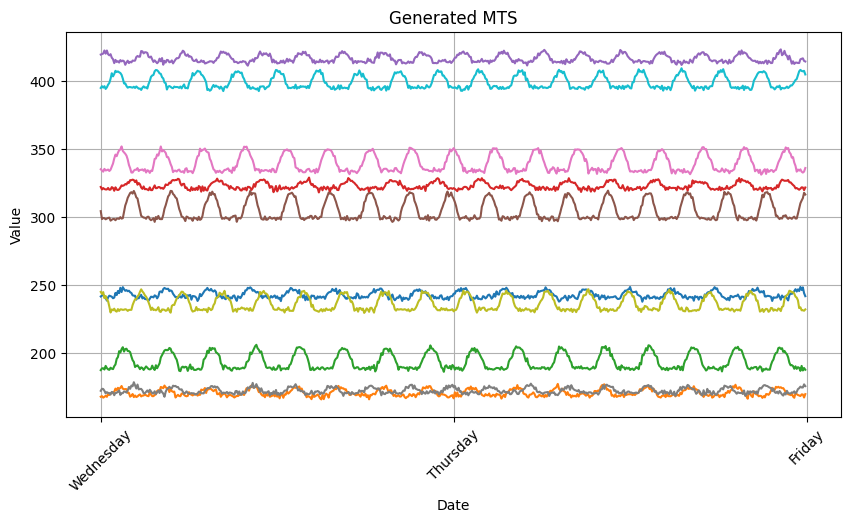

In [96]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="Seasonality",
                                                           occurance=1,
                                                           return_gen=True,
                                                           anomalies=False)

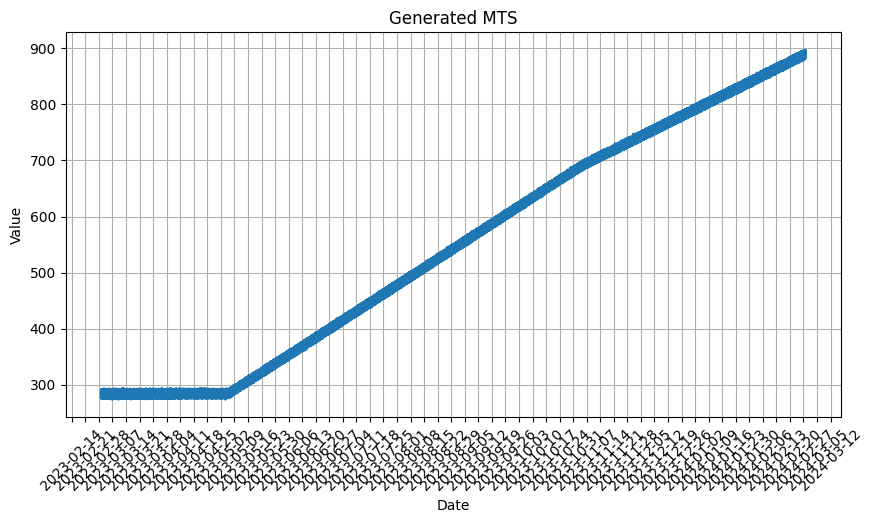

In [135]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [5]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

NameError: name 'train_data_long' is not defined

In [97]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
# labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

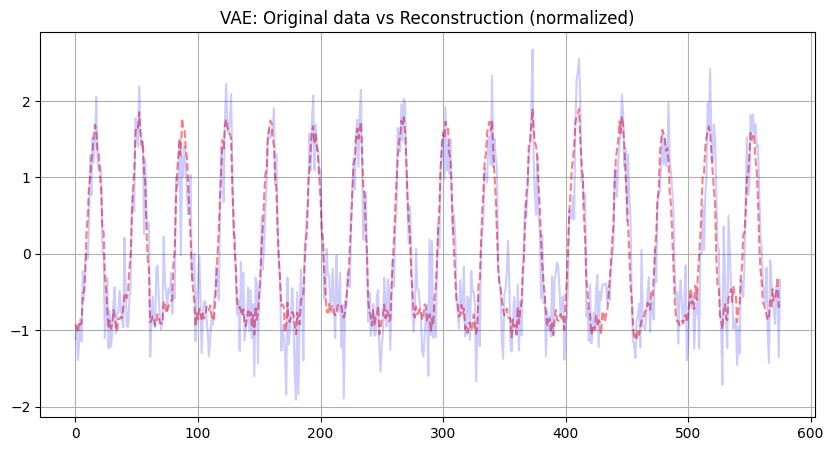

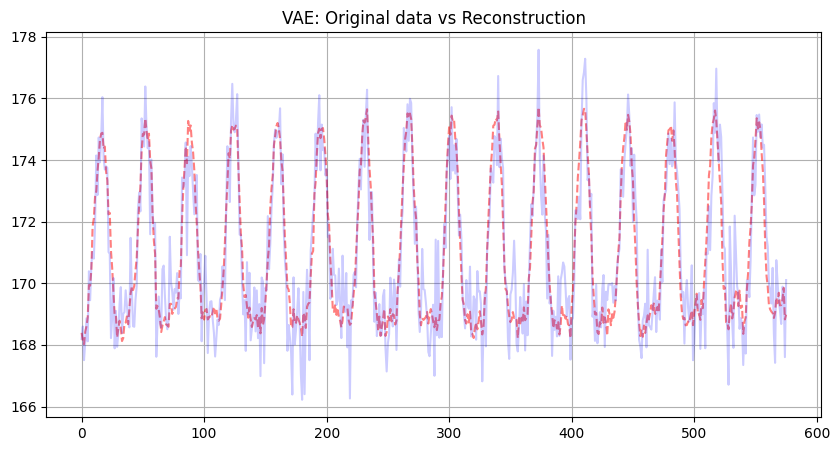

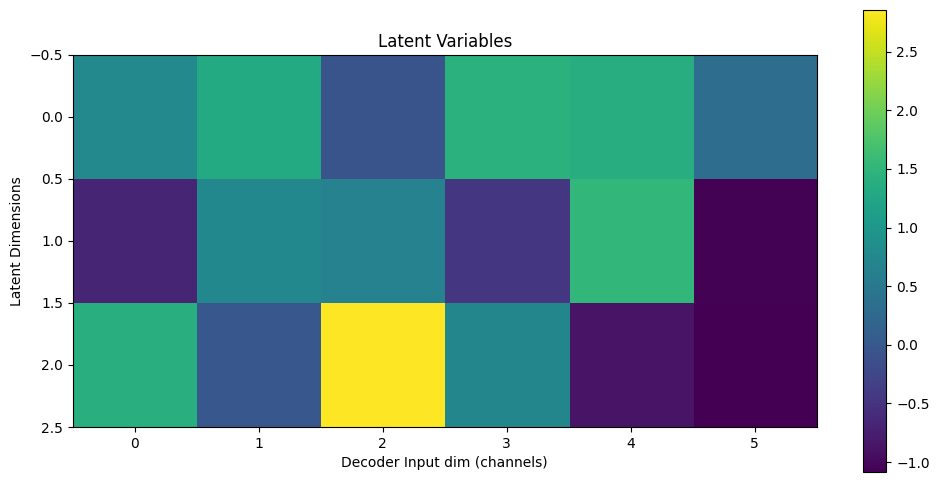

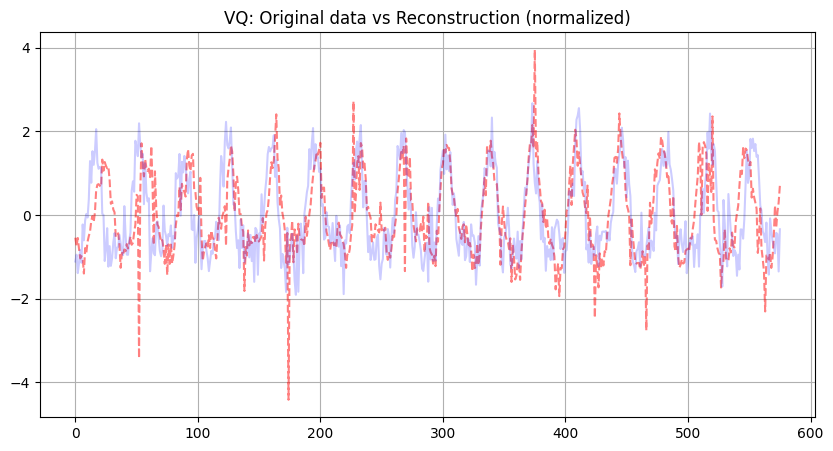

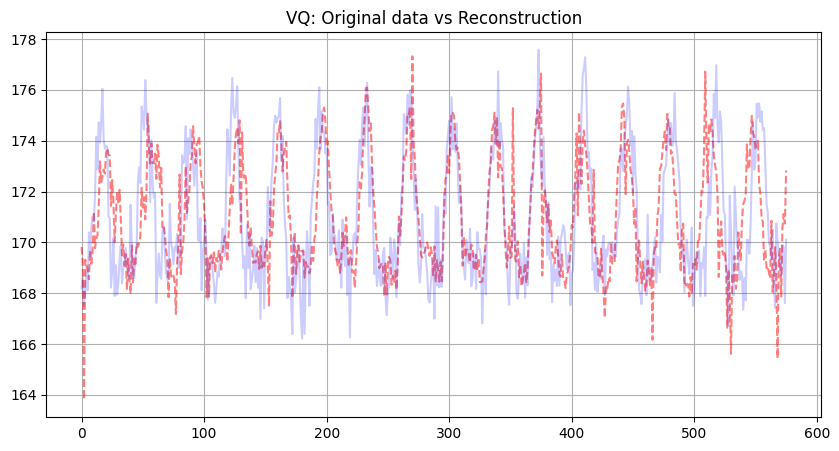

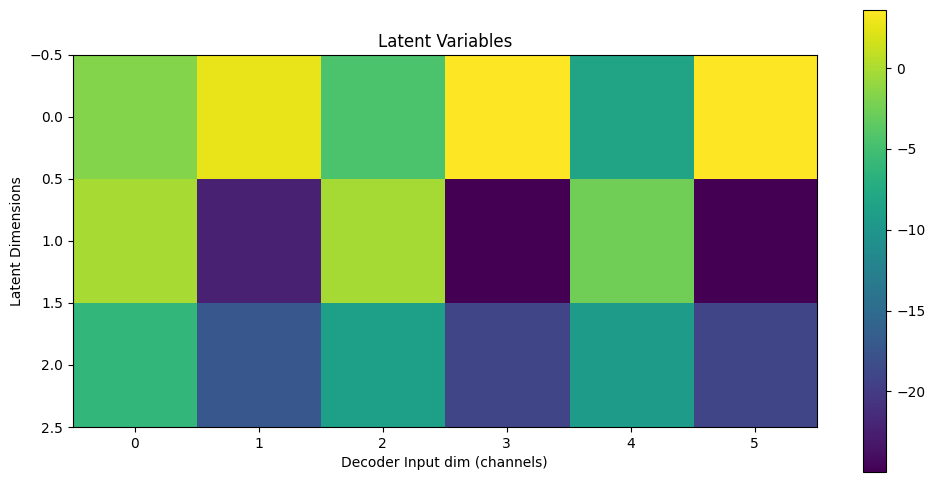

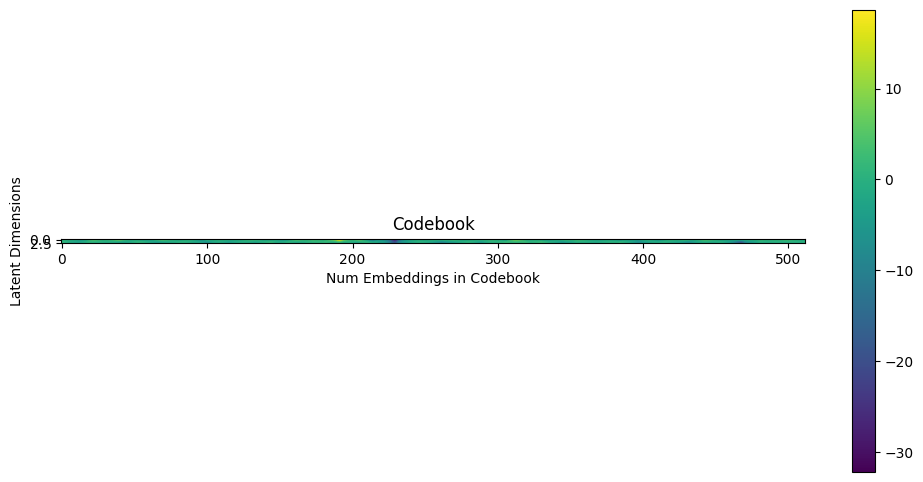

====> VAE: Sample 901 Average loss: 0.1684
====> VQ: Sample 901 Average loss: 0.3502
Train Epoch: 902 [0/4 (0%)]	Loss: 134.108185	 True Loss: 34331.695312
Train Epoch: 902 [0/4 (0%)]	Loss: 279.425598	 True Loss: 71532.953125
====> VAE: Sample 902 Average loss: 0.1694
====> VQ: Sample 902 Average loss: 0.3480
Train Epoch: 903 [0/4 (0%)]	Loss: 136.858490	 True Loss: 35035.773438
Train Epoch: 903 [0/4 (0%)]	Loss: 279.271973	 True Loss: 71493.625000
====> VAE: Sample 903 Average loss: 0.1709
====> VQ: Sample 903 Average loss: 0.3464
Train Epoch: 904 [0/4 (0%)]	Loss: 136.868790	 True Loss: 35038.410156
Train Epoch: 904 [0/4 (0%)]	Loss: 282.182159	 True Loss: 72238.632812
====> VAE: Sample 904 Average loss: 0.1685
====> VQ: Sample 904 Average loss: 0.3475
Train Epoch: 905 [0/4 (0%)]	Loss: 137.713684	 True Loss: 35254.703125
Train Epoch: 905 [0/4 (0%)]	Loss: 277.246704	 True Loss: 70975.156250
====> VAE: Sample 905 Average loss: 0.1701
====> VQ: Sample 905 Average loss: 0.3446
Train Epoch: 90

Train Epoch: 938 [0/4 (0%)]	Loss: 276.363678	 True Loss: 70749.101562
====> VAE: Sample 938 Average loss: 0.1676
====> VQ: Sample 938 Average loss: 0.3318
Train Epoch: 939 [0/4 (0%)]	Loss: 135.115829	 True Loss: 34589.652344
Train Epoch: 939 [0/4 (0%)]	Loss: 269.897217	 True Loss: 69093.687500
====> VAE: Sample 939 Average loss: 0.1676
====> VQ: Sample 939 Average loss: 0.3313
Train Epoch: 940 [0/4 (0%)]	Loss: 135.096436	 True Loss: 34584.687500
Train Epoch: 940 [0/4 (0%)]	Loss: 264.109985	 True Loss: 67612.156250
====> VAE: Sample 940 Average loss: 0.1678
====> VQ: Sample 940 Average loss: 0.3276
Train Epoch: 941 [0/4 (0%)]	Loss: 136.446686	 True Loss: 34930.351562
Train Epoch: 941 [0/4 (0%)]	Loss: 268.260162	 True Loss: 68674.601562
====> VAE: Sample 941 Average loss: 0.1690
====> VQ: Sample 941 Average loss: 0.3338
Train Epoch: 942 [0/4 (0%)]	Loss: 133.170380	 True Loss: 34091.617188
Train Epoch: 942 [0/4 (0%)]	Loss: 264.561676	 True Loss: 67727.789062
====> VAE: Sample 942 Average 

Train Epoch: 975 [0/4 (0%)]	Loss: 267.609131	 True Loss: 68507.937500
====> VAE: Sample 975 Average loss: 0.1672
====> VQ: Sample 975 Average loss: 0.3244
Train Epoch: 976 [0/4 (0%)]	Loss: 135.065735	 True Loss: 34576.828125
Train Epoch: 976 [0/4 (0%)]	Loss: 258.964081	 True Loss: 66294.804688
====> VAE: Sample 976 Average loss: 0.1683
====> VQ: Sample 976 Average loss: 0.3242
Train Epoch: 977 [0/4 (0%)]	Loss: 138.772919	 True Loss: 35525.867188
Train Epoch: 977 [0/4 (0%)]	Loss: 262.162933	 True Loss: 67113.710938
====> VAE: Sample 977 Average loss: 0.1683
====> VQ: Sample 977 Average loss: 0.3259
Train Epoch: 978 [0/4 (0%)]	Loss: 137.495010	 True Loss: 35198.722656
Train Epoch: 978 [0/4 (0%)]	Loss: 261.222534	 True Loss: 66872.968750
====> VAE: Sample 978 Average loss: 0.1699
====> VQ: Sample 978 Average loss: 0.3203
Train Epoch: 979 [0/4 (0%)]	Loss: 136.218216	 True Loss: 34871.863281
Train Epoch: 979 [0/4 (0%)]	Loss: 264.340912	 True Loss: 67671.273438
====> VAE: Sample 979 Average 

In [98]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 1000):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args, plot_latent=False)
        show_results(vq, train_data, args, vq=True, plot_latent=False)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [99]:
from disentangelement import identifier
id_mlp_vae = identifier(args=args, n_layers=1, output_size=labels.shape[-1])
id_mlp_vq = identifier(args=args, n_layers=1, output_size=labels.shape[-1])

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.001)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.001)

In [110]:
id_mlp_vae = id_mlp_vae.to("cuda")
id_mlp_vq = id_mlp_vq.to("cuda")
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)
id_mlp_vae = id_mlp_vae.to("cpu")
id_mlp_vq = id_mlp_vq.to("cpu")

Train Epoch: 1 [0/800 (0%)]	Loss: 5.513991
====> Epoch: 1 Average loss: 6.7769
True Loss:  5421.5491943359375
Train Epoch: 1 [0/800 (0%)]	Loss: 0.448483
====> Epoch: 1 Average loss: 0.5460
True Loss:  436.8260498046875
Train Epoch: 2 [0/800 (0%)]	Loss: 5.777160
====> Epoch: 2 Average loss: 6.9824
True Loss:  5585.896484375
Train Epoch: 2 [0/800 (0%)]	Loss: 0.461450
====> Epoch: 2 Average loss: 0.5537
True Loss:  442.9714889526367
Train Epoch: 3 [0/800 (0%)]	Loss: 5.474315
====> Epoch: 3 Average loss: 7.0511
True Loss:  5640.91650390625
Train Epoch: 3 [0/800 (0%)]	Loss: 0.494979
====> Epoch: 3 Average loss: 0.5700
True Loss:  455.9728698730469
Train Epoch: 4 [0/800 (0%)]	Loss: 5.525542
====> Epoch: 4 Average loss: 7.1254
True Loss:  5700.3497314453125
Train Epoch: 4 [0/800 (0%)]	Loss: 0.450884
====> Epoch: 4 Average loss: 0.5546
True Loss:  443.6948547363281
Train Epoch: 5 [0/800 (0%)]	Loss: 5.544388
====> Epoch: 5 Average loss: 7.0153
True Loss:  5612.2489013671875
Train Epoch: 5 [0/80

Train Epoch: 39 [0/800 (0%)]	Loss: 5.519862
====> Epoch: 39 Average loss: 7.1120
True Loss:  5689.623291015625
Train Epoch: 39 [0/800 (0%)]	Loss: 0.469471
====> Epoch: 39 Average loss: 0.5549
True Loss:  443.88397216796875
Train Epoch: 40 [0/800 (0%)]	Loss: 5.405562
====> Epoch: 40 Average loss: 7.0025
True Loss:  5601.964111328125
Train Epoch: 40 [0/800 (0%)]	Loss: 0.461804
====> Epoch: 40 Average loss: 0.5376
True Loss:  430.10099029541016
Train Epoch: 41 [0/800 (0%)]	Loss: 5.490870
====> Epoch: 41 Average loss: 7.1440
True Loss:  5715.1629638671875
Train Epoch: 41 [0/800 (0%)]	Loss: 0.464696
====> Epoch: 41 Average loss: 0.5448
True Loss:  435.8487319946289
Train Epoch: 42 [0/800 (0%)]	Loss: 5.501539
====> Epoch: 42 Average loss: 6.9426
True Loss:  5554.09619140625
Train Epoch: 42 [0/800 (0%)]	Loss: 0.448495
====> Epoch: 42 Average loss: 0.5412
True Loss:  432.9276809692383
Train Epoch: 43 [0/800 (0%)]	Loss: 5.558688
====> Epoch: 43 Average loss: 6.9297
True Loss:  5543.741088867187

====> Epoch: 76 Average loss: 6.8827
True Loss:  5506.168701171875
Train Epoch: 76 [0/800 (0%)]	Loss: 0.457184
====> Epoch: 76 Average loss: 0.5259
True Loss:  420.73986053466797
Train Epoch: 77 [0/800 (0%)]	Loss: 5.602896
====> Epoch: 77 Average loss: 7.0233
True Loss:  5618.6707763671875
Train Epoch: 77 [0/800 (0%)]	Loss: 0.474589
====> Epoch: 77 Average loss: 0.5646
True Loss:  451.7132263183594
Train Epoch: 78 [0/800 (0%)]	Loss: 5.389118
====> Epoch: 78 Average loss: 6.8503
True Loss:  5480.250244140625
Train Epoch: 78 [0/800 (0%)]	Loss: 0.445629
====> Epoch: 78 Average loss: 0.5440
True Loss:  435.1717529296875
Train Epoch: 79 [0/800 (0%)]	Loss: 5.247238
====> Epoch: 79 Average loss: 6.9204
True Loss:  5536.3201904296875
Train Epoch: 79 [0/800 (0%)]	Loss: 0.464579
====> Epoch: 79 Average loss: 0.5526
True Loss:  442.0854263305664
Train Epoch: 80 [0/800 (0%)]	Loss: 5.397987
====> Epoch: 80 Average loss: 6.9560
True Loss:  5564.7623291015625
Train Epoch: 80 [0/800 (0%)]	Loss: 0.4726

====> Epoch: 113 Average loss: 6.7964
True Loss:  5437.154541015625
Train Epoch: 113 [0/800 (0%)]	Loss: 0.442773
====> Epoch: 113 Average loss: 0.5260
True Loss:  420.8073043823242
Train Epoch: 114 [0/800 (0%)]	Loss: 5.308259
====> Epoch: 114 Average loss: 6.7594
True Loss:  5407.551025390625
Train Epoch: 114 [0/800 (0%)]	Loss: 0.427914
====> Epoch: 114 Average loss: 0.5240
True Loss:  419.1965866088867
Train Epoch: 115 [0/800 (0%)]	Loss: 5.441014
====> Epoch: 115 Average loss: 6.8693
True Loss:  5495.4532470703125
Train Epoch: 115 [0/800 (0%)]	Loss: 0.440839
====> Epoch: 115 Average loss: 0.5099
True Loss:  407.88446044921875
Train Epoch: 116 [0/800 (0%)]	Loss: 5.377909
====> Epoch: 116 Average loss: 6.7120
True Loss:  5369.5601806640625
Train Epoch: 116 [0/800 (0%)]	Loss: 0.449847
====> Epoch: 116 Average loss: 0.5190
True Loss:  415.1868667602539
Train Epoch: 117 [0/800 (0%)]	Loss: 5.358288
====> Epoch: 117 Average loss: 6.8216
True Loss:  5457.268798828125
Train Epoch: 117 [0/800 (

====> Epoch: 150 Average loss: 6.7470
True Loss:  5397.6390380859375
Train Epoch: 150 [0/800 (0%)]	Loss: 0.448009
====> Epoch: 150 Average loss: 0.5315
True Loss:  425.20906829833984
Train Epoch: 151 [0/800 (0%)]	Loss: 5.215652
====> Epoch: 151 Average loss: 6.9824
True Loss:  5585.901123046875
Train Epoch: 151 [0/800 (0%)]	Loss: 0.429119
====> Epoch: 151 Average loss: 0.5167
True Loss:  413.3738784790039
Train Epoch: 152 [0/800 (0%)]	Loss: 5.397512
====> Epoch: 152 Average loss: 6.8499
True Loss:  5479.9576416015625
Train Epoch: 152 [0/800 (0%)]	Loss: 0.438993
====> Epoch: 152 Average loss: 0.5180
True Loss:  414.36940002441406
Train Epoch: 153 [0/800 (0%)]	Loss: 5.319234
====> Epoch: 153 Average loss: 6.9720
True Loss:  5577.635009765625
Train Epoch: 153 [0/800 (0%)]	Loss: 0.427735
====> Epoch: 153 Average loss: 0.5005
True Loss:  400.3717803955078
Train Epoch: 154 [0/800 (0%)]	Loss: 5.417805
====> Epoch: 154 Average loss: 6.9844
True Loss:  5587.543212890625
Train Epoch: 154 [0/800 

====> Epoch: 187 Average loss: 6.8826
True Loss:  5506.088134765625
Train Epoch: 187 [0/800 (0%)]	Loss: 0.433940
====> Epoch: 187 Average loss: 0.5093
True Loss:  407.4609375
Train Epoch: 188 [0/800 (0%)]	Loss: 5.154447
====> Epoch: 188 Average loss: 6.8584
True Loss:  5486.7430419921875
Train Epoch: 188 [0/800 (0%)]	Loss: 0.440579
====> Epoch: 188 Average loss: 0.5527
True Loss:  442.15867614746094
Train Epoch: 189 [0/800 (0%)]	Loss: 5.343695
====> Epoch: 189 Average loss: 6.8258
True Loss:  5460.605712890625
Train Epoch: 189 [0/800 (0%)]	Loss: 0.448458
====> Epoch: 189 Average loss: 0.5024
True Loss:  401.9054870605469
Train Epoch: 190 [0/800 (0%)]	Loss: 5.489184
====> Epoch: 190 Average loss: 6.8036
True Loss:  5442.8687744140625
Train Epoch: 190 [0/800 (0%)]	Loss: 0.454031
====> Epoch: 190 Average loss: 0.5411
True Loss:  432.8567581176758
Train Epoch: 191 [0/800 (0%)]	Loss: 5.370461
====> Epoch: 191 Average loss: 6.9696
True Loss:  5575.67724609375
Train Epoch: 191 [0/800 (0%)]	Lo

====> Epoch: 224 Average loss: 6.7393
True Loss:  5391.4246826171875
Train Epoch: 224 [0/800 (0%)]	Loss: 0.444052
====> Epoch: 224 Average loss: 0.5299
True Loss:  423.90538024902344
Train Epoch: 225 [0/800 (0%)]	Loss: 5.103992
====> Epoch: 225 Average loss: 6.5986
True Loss:  5278.845458984375
Train Epoch: 225 [0/800 (0%)]	Loss: 0.424181
====> Epoch: 225 Average loss: 0.5267
True Loss:  421.3392333984375
Train Epoch: 226 [0/800 (0%)]	Loss: 5.226629
====> Epoch: 226 Average loss: 6.8242
True Loss:  5459.3909912109375
Train Epoch: 226 [0/800 (0%)]	Loss: 0.401448
====> Epoch: 226 Average loss: 0.5349
True Loss:  427.89693450927734
Train Epoch: 227 [0/800 (0%)]	Loss: 5.199390
====> Epoch: 227 Average loss: 6.7184
True Loss:  5374.7225341796875
Train Epoch: 227 [0/800 (0%)]	Loss: 0.458652
====> Epoch: 227 Average loss: 0.5296
True Loss:  423.7068405151367
Train Epoch: 228 [0/800 (0%)]	Loss: 5.246928
====> Epoch: 228 Average loss: 6.7752
True Loss:  5420.1229248046875
Train Epoch: 228 [0/80

====> Epoch: 261 Average loss: 6.5374
True Loss:  5229.939453125
Train Epoch: 261 [0/800 (0%)]	Loss: 0.408736
====> Epoch: 261 Average loss: 0.4924
True Loss:  393.89483642578125
Train Epoch: 262 [0/800 (0%)]	Loss: 5.280970
====> Epoch: 262 Average loss: 6.5676
True Loss:  5254.0582275390625
Train Epoch: 262 [0/800 (0%)]	Loss: 0.412985
====> Epoch: 262 Average loss: 0.5096
True Loss:  407.7177276611328
Train Epoch: 263 [0/800 (0%)]	Loss: 5.134809
====> Epoch: 263 Average loss: 6.4891
True Loss:  5191.316162109375
Train Epoch: 263 [0/800 (0%)]	Loss: 0.424159
====> Epoch: 263 Average loss: 0.5253
True Loss:  420.2024383544922
Train Epoch: 264 [0/800 (0%)]	Loss: 5.294861
====> Epoch: 264 Average loss: 6.6175
True Loss:  5293.9630126953125
Train Epoch: 264 [0/800 (0%)]	Loss: 0.461007
====> Epoch: 264 Average loss: 0.5221
True Loss:  417.7133560180664
Train Epoch: 265 [0/800 (0%)]	Loss: 4.930144
====> Epoch: 265 Average loss: 6.6421
True Loss:  5313.674072265625
Train Epoch: 265 [0/800 (0%)

====> Epoch: 298 Average loss: 6.5966
True Loss:  5277.3189697265625
Train Epoch: 298 [0/800 (0%)]	Loss: 0.421296
====> Epoch: 298 Average loss: 0.5035
True Loss:  402.7693786621094
Train Epoch: 299 [0/800 (0%)]	Loss: 5.077998
====> Epoch: 299 Average loss: 6.6543
True Loss:  5323.470703125
Train Epoch: 299 [0/800 (0%)]	Loss: 0.409393
====> Epoch: 299 Average loss: 0.4895
True Loss:  391.56912994384766
Train Epoch: 300 [0/800 (0%)]	Loss: 4.981118
====> Epoch: 300 Average loss: 6.4996
True Loss:  5199.68212890625
Train Epoch: 300 [0/800 (0%)]	Loss: 0.445049
====> Epoch: 300 Average loss: 0.5273
True Loss:  421.8594970703125
Train Epoch: 301 [0/800 (0%)]	Loss: 5.254454
====> Epoch: 301 Average loss: 6.6017
True Loss:  5281.3675537109375
Train Epoch: 301 [0/800 (0%)]	Loss: 0.425195
====> Epoch: 301 Average loss: 0.5124
True Loss:  409.9506607055664
Train Epoch: 302 [0/800 (0%)]	Loss: 5.103619
====> Epoch: 302 Average loss: 6.4614
True Loss:  5169.141845703125
Train Epoch: 302 [0/800 (0%)]

====> Epoch: 335 Average loss: 6.5552
True Loss:  5244.1806640625
Train Epoch: 335 [0/800 (0%)]	Loss: 0.417986
====> Epoch: 335 Average loss: 0.5161
True Loss:  412.90103912353516
Train Epoch: 336 [0/800 (0%)]	Loss: 5.083027
====> Epoch: 336 Average loss: 6.4167
True Loss:  5133.3333740234375
Train Epoch: 336 [0/800 (0%)]	Loss: 0.421264
====> Epoch: 336 Average loss: 0.5000
True Loss:  400.0337677001953
Train Epoch: 337 [0/800 (0%)]	Loss: 5.099061
====> Epoch: 337 Average loss: 6.6362
True Loss:  5308.99609375
Train Epoch: 337 [0/800 (0%)]	Loss: 0.403100
====> Epoch: 337 Average loss: 0.5000
True Loss:  399.9954605102539
Train Epoch: 338 [0/800 (0%)]	Loss: 5.139120
====> Epoch: 338 Average loss: 6.3861
True Loss:  5108.8841552734375
Train Epoch: 338 [0/800 (0%)]	Loss: 0.416198
====> Epoch: 338 Average loss: 0.5160
True Loss:  412.7851867675781
Train Epoch: 339 [0/800 (0%)]	Loss: 5.101208
====> Epoch: 339 Average loss: 6.4299
True Loss:  5143.9114990234375
Train Epoch: 339 [0/800 (0%)]	

====> Epoch: 372 Average loss: 6.4351
True Loss:  5148.0970458984375
Train Epoch: 372 [0/800 (0%)]	Loss: 0.393712
====> Epoch: 372 Average loss: 0.5034
True Loss:  402.7163772583008
Train Epoch: 373 [0/800 (0%)]	Loss: 4.932600
====> Epoch: 373 Average loss: 6.4936
True Loss:  5194.8553466796875
Train Epoch: 373 [0/800 (0%)]	Loss: 0.406922
====> Epoch: 373 Average loss: 0.4903
True Loss:  392.2233428955078
Train Epoch: 374 [0/800 (0%)]	Loss: 5.223598
====> Epoch: 374 Average loss: 6.4986
True Loss:  5198.86962890625
Train Epoch: 374 [0/800 (0%)]	Loss: 0.446140
====> Epoch: 374 Average loss: 0.5011
True Loss:  400.86376190185547
Train Epoch: 375 [0/800 (0%)]	Loss: 5.017470
====> Epoch: 375 Average loss: 6.2469
True Loss:  4997.5191650390625
Train Epoch: 375 [0/800 (0%)]	Loss: 0.411491
====> Epoch: 375 Average loss: 0.4934
True Loss:  394.6854705810547
Train Epoch: 376 [0/800 (0%)]	Loss: 5.136112
====> Epoch: 376 Average loss: 6.5155
True Loss:  5212.4168701171875
Train Epoch: 376 [0/800 

====> Epoch: 409 Average loss: 6.3745
True Loss:  5099.576171875
Train Epoch: 409 [0/800 (0%)]	Loss: 0.419859
====> Epoch: 409 Average loss: 0.5278
True Loss:  422.24220275878906
Train Epoch: 410 [0/800 (0%)]	Loss: 4.829735
====> Epoch: 410 Average loss: 6.2505
True Loss:  5000.4217529296875
Train Epoch: 410 [0/800 (0%)]	Loss: 0.405669
====> Epoch: 410 Average loss: 0.4890
True Loss:  391.17615509033203
Train Epoch: 411 [0/800 (0%)]	Loss: 4.796779
====> Epoch: 411 Average loss: 6.3491
True Loss:  5079.2578125
Train Epoch: 411 [0/800 (0%)]	Loss: 0.374991
====> Epoch: 411 Average loss: 0.4781
True Loss:  382.4939270019531
Train Epoch: 412 [0/800 (0%)]	Loss: 4.996411
====> Epoch: 412 Average loss: 6.4237
True Loss:  5138.9786376953125
Train Epoch: 412 [0/800 (0%)]	Loss: 0.365090
====> Epoch: 412 Average loss: 0.4592
True Loss:  367.34190368652344
Train Epoch: 413 [0/800 (0%)]	Loss: 5.094105
====> Epoch: 413 Average loss: 6.3557
True Loss:  5084.581298828125
Train Epoch: 413 [0/800 (0%)]	L

====> Epoch: 446 Average loss: 6.3269
True Loss:  5061.5101318359375
Train Epoch: 446 [0/800 (0%)]	Loss: 0.424446
====> Epoch: 446 Average loss: 0.4732
True Loss:  378.54127502441406
Train Epoch: 447 [0/800 (0%)]	Loss: 4.971755
====> Epoch: 447 Average loss: 6.4978
True Loss:  5198.200439453125
Train Epoch: 447 [0/800 (0%)]	Loss: 0.400419
====> Epoch: 447 Average loss: 0.5043
True Loss:  403.4796447753906
Train Epoch: 448 [0/800 (0%)]	Loss: 5.205984
====> Epoch: 448 Average loss: 6.5063
True Loss:  5205.0318603515625
Train Epoch: 448 [0/800 (0%)]	Loss: 0.426026
====> Epoch: 448 Average loss: 0.4769
True Loss:  381.48767852783203
Train Epoch: 449 [0/800 (0%)]	Loss: 5.289611
====> Epoch: 449 Average loss: 6.4520
True Loss:  5161.6357421875
Train Epoch: 449 [0/800 (0%)]	Loss: 0.402488
====> Epoch: 449 Average loss: 0.5292
True Loss:  423.37154388427734
Train Epoch: 450 [0/800 (0%)]	Loss: 5.070693
====> Epoch: 450 Average loss: 6.3187
True Loss:  5054.968505859375
Train Epoch: 450 [0/800 (

====> Epoch: 483 Average loss: 6.3835
True Loss:  5106.794921875
Train Epoch: 483 [0/800 (0%)]	Loss: 0.403612
====> Epoch: 483 Average loss: 0.4690
True Loss:  375.23582458496094
Train Epoch: 484 [0/800 (0%)]	Loss: 4.993167
====> Epoch: 484 Average loss: 6.5395
True Loss:  5231.6251220703125
Train Epoch: 484 [0/800 (0%)]	Loss: 0.391101
====> Epoch: 484 Average loss: 0.4659
True Loss:  372.75093841552734
Train Epoch: 485 [0/800 (0%)]	Loss: 4.952619
====> Epoch: 485 Average loss: 6.4417
True Loss:  5153.33935546875
Train Epoch: 485 [0/800 (0%)]	Loss: 0.412881
====> Epoch: 485 Average loss: 0.4692
True Loss:  375.3531494140625
Train Epoch: 486 [0/800 (0%)]	Loss: 5.160411
====> Epoch: 486 Average loss: 6.1238
True Loss:  4899.0128173828125
Train Epoch: 486 [0/800 (0%)]	Loss: 0.393470
====> Epoch: 486 Average loss: 0.4643
True Loss:  371.47662353515625
Train Epoch: 487 [0/800 (0%)]	Loss: 4.788838
====> Epoch: 487 Average loss: 6.4129
True Loss:  5130.28857421875
Train Epoch: 487 [0/800 (0%)

====> Epoch: 520 Average loss: 6.3783
True Loss:  5102.6317138671875
Train Epoch: 520 [0/800 (0%)]	Loss: 0.401403
====> Epoch: 520 Average loss: 0.4839
True Loss:  387.0926742553711
Train Epoch: 521 [0/800 (0%)]	Loss: 4.988079
====> Epoch: 521 Average loss: 6.2863
True Loss:  5029.0606689453125
Train Epoch: 521 [0/800 (0%)]	Loss: 0.404855
====> Epoch: 521 Average loss: 0.4588
True Loss:  367.0517272949219
Train Epoch: 522 [0/800 (0%)]	Loss: 4.769899
====> Epoch: 522 Average loss: 6.3160
True Loss:  5052.797119140625
Train Epoch: 522 [0/800 (0%)]	Loss: 0.410743
====> Epoch: 522 Average loss: 0.4825
True Loss:  385.9961929321289
Train Epoch: 523 [0/800 (0%)]	Loss: 5.010871
====> Epoch: 523 Average loss: 6.3129
True Loss:  5050.30126953125
Train Epoch: 523 [0/800 (0%)]	Loss: 0.400859
====> Epoch: 523 Average loss: 0.4642
True Loss:  371.32337188720703
Train Epoch: 524 [0/800 (0%)]	Loss: 4.967352
====> Epoch: 524 Average loss: 6.3363
True Loss:  5069.0206298828125
Train Epoch: 524 [0/800 (

====> Epoch: 557 Average loss: 6.3281
True Loss:  5062.46240234375
Train Epoch: 557 [0/800 (0%)]	Loss: 0.408117
====> Epoch: 557 Average loss: 0.4717
True Loss:  377.33538818359375
Train Epoch: 558 [0/800 (0%)]	Loss: 4.922485
====> Epoch: 558 Average loss: 6.1101
True Loss:  4888.0762939453125
Train Epoch: 558 [0/800 (0%)]	Loss: 0.419999
====> Epoch: 558 Average loss: 0.4640
True Loss:  371.16400146484375
Train Epoch: 559 [0/800 (0%)]	Loss: 4.979228
====> Epoch: 559 Average loss: 6.2889
True Loss:  5031.0819091796875
Train Epoch: 559 [0/800 (0%)]	Loss: 0.421887
====> Epoch: 559 Average loss: 0.4807
True Loss:  384.5288314819336
Train Epoch: 560 [0/800 (0%)]	Loss: 5.089793
====> Epoch: 560 Average loss: 6.1817
True Loss:  4945.337890625
Train Epoch: 560 [0/800 (0%)]	Loss: 0.407806
====> Epoch: 560 Average loss: 0.4649
True Loss:  371.9159851074219
Train Epoch: 561 [0/800 (0%)]	Loss: 4.929221
====> Epoch: 561 Average loss: 6.2413
True Loss:  4993.0682373046875
Train Epoch: 561 [0/800 (0%

====> Epoch: 594 Average loss: 6.0416
True Loss:  4833.31298828125
Train Epoch: 594 [0/800 (0%)]	Loss: 0.403175
====> Epoch: 594 Average loss: 0.4501
True Loss:  360.07576751708984
Train Epoch: 595 [0/800 (0%)]	Loss: 4.844986
====> Epoch: 595 Average loss: 6.2044
True Loss:  4963.54833984375
Train Epoch: 595 [0/800 (0%)]	Loss: 0.410618
====> Epoch: 595 Average loss: 0.4509
True Loss:  360.7337951660156
Train Epoch: 596 [0/800 (0%)]	Loss: 4.889224
====> Epoch: 596 Average loss: 6.3116
True Loss:  5049.252197265625
Train Epoch: 596 [0/800 (0%)]	Loss: 0.397817
====> Epoch: 596 Average loss: 0.4574
True Loss:  365.9247055053711
Train Epoch: 597 [0/800 (0%)]	Loss: 4.938512
====> Epoch: 597 Average loss: 6.3049
True Loss:  5043.9219970703125
Train Epoch: 597 [0/800 (0%)]	Loss: 0.378966
====> Epoch: 597 Average loss: 0.4502
True Loss:  360.1885757446289
Train Epoch: 598 [0/800 (0%)]	Loss: 5.019446
====> Epoch: 598 Average loss: 6.2022
True Loss:  4961.79248046875
Train Epoch: 598 [0/800 (0%)]

====> Epoch: 631 Average loss: 5.9659
True Loss:  4772.7318115234375
Train Epoch: 631 [0/800 (0%)]	Loss: 0.419070
====> Epoch: 631 Average loss: 0.4737
True Loss:  378.9347610473633
Train Epoch: 632 [0/800 (0%)]	Loss: 4.893736
====> Epoch: 632 Average loss: 6.1923
True Loss:  4953.823974609375
Train Epoch: 632 [0/800 (0%)]	Loss: 0.411191
====> Epoch: 632 Average loss: 0.4832
True Loss:  386.52838134765625
Train Epoch: 633 [0/800 (0%)]	Loss: 5.041076
====> Epoch: 633 Average loss: 6.2162
True Loss:  4972.9287109375
Train Epoch: 633 [0/800 (0%)]	Loss: 0.389403
====> Epoch: 633 Average loss: 0.4516
True Loss:  361.24732208251953
Train Epoch: 634 [0/800 (0%)]	Loss: 4.927462
====> Epoch: 634 Average loss: 6.3094
True Loss:  5047.501708984375
Train Epoch: 634 [0/800 (0%)]	Loss: 0.393256
====> Epoch: 634 Average loss: 0.4517
True Loss:  361.39513397216797
Train Epoch: 635 [0/800 (0%)]	Loss: 4.498832
====> Epoch: 635 Average loss: 5.9605
True Loss:  4768.376220703125
Train Epoch: 635 [0/800 (0

====> Epoch: 668 Average loss: 6.0230
True Loss:  4818.363037109375
Train Epoch: 668 [0/800 (0%)]	Loss: 0.399882
====> Epoch: 668 Average loss: 0.4570
True Loss:  365.59439849853516
Train Epoch: 669 [0/800 (0%)]	Loss: 4.824548
====> Epoch: 669 Average loss: 5.8572
True Loss:  4685.767150878906
Train Epoch: 669 [0/800 (0%)]	Loss: 0.382308
====> Epoch: 669 Average loss: 0.4586
True Loss:  366.87054443359375
Train Epoch: 670 [0/800 (0%)]	Loss: 4.763104
====> Epoch: 670 Average loss: 5.9423
True Loss:  4753.8643798828125
Train Epoch: 670 [0/800 (0%)]	Loss: 0.374527
====> Epoch: 670 Average loss: 0.4297
True Loss:  343.73846435546875
Train Epoch: 671 [0/800 (0%)]	Loss: 4.734031
====> Epoch: 671 Average loss: 6.0392
True Loss:  4831.37841796875
Train Epoch: 671 [0/800 (0%)]	Loss: 0.400119
====> Epoch: 671 Average loss: 0.4556
True Loss:  364.50203704833984
Train Epoch: 672 [0/800 (0%)]	Loss: 4.719642
====> Epoch: 672 Average loss: 6.1522
True Loss:  4921.7845458984375
Train Epoch: 672 [0/800

====> Epoch: 705 Average loss: 6.0280
True Loss:  4822.39306640625
Train Epoch: 705 [0/800 (0%)]	Loss: 0.369404
====> Epoch: 705 Average loss: 0.4761
True Loss:  380.9086608886719
Train Epoch: 706 [0/800 (0%)]	Loss: 4.810200
====> Epoch: 706 Average loss: 6.0177
True Loss:  4814.156982421875
Train Epoch: 706 [0/800 (0%)]	Loss: 0.358252
====> Epoch: 706 Average loss: 0.4610
True Loss:  368.7922897338867
Train Epoch: 707 [0/800 (0%)]	Loss: 4.774719
====> Epoch: 707 Average loss: 6.2188
True Loss:  4975.0731201171875
Train Epoch: 707 [0/800 (0%)]	Loss: 0.381373
====> Epoch: 707 Average loss: 0.4351
True Loss:  348.0899887084961
Train Epoch: 708 [0/800 (0%)]	Loss: 5.098845
====> Epoch: 708 Average loss: 6.2390
True Loss:  4991.225341796875
Train Epoch: 708 [0/800 (0%)]	Loss: 0.394182
====> Epoch: 708 Average loss: 0.4475
True Loss:  357.97218322753906
Train Epoch: 709 [0/800 (0%)]	Loss: 4.851615
====> Epoch: 709 Average loss: 6.0812
True Loss:  4864.973388671875
Train Epoch: 709 [0/800 (0%

====> Epoch: 742 Average loss: 5.8213
True Loss:  4657.0220947265625
Train Epoch: 742 [0/800 (0%)]	Loss: 0.394830
====> Epoch: 742 Average loss: 0.4602
True Loss:  368.16151428222656
Train Epoch: 743 [0/800 (0%)]	Loss: 4.430160
====> Epoch: 743 Average loss: 5.9250
True Loss:  4739.96630859375
Train Epoch: 743 [0/800 (0%)]	Loss: 0.386697
====> Epoch: 743 Average loss: 0.4520
True Loss:  361.59532928466797
Train Epoch: 744 [0/800 (0%)]	Loss: 4.747100
====> Epoch: 744 Average loss: 5.9749
True Loss:  4779.9119873046875
Train Epoch: 744 [0/800 (0%)]	Loss: 0.374962
====> Epoch: 744 Average loss: 0.4717
True Loss:  377.34932708740234
Train Epoch: 745 [0/800 (0%)]	Loss: 4.739596
====> Epoch: 745 Average loss: 6.0282
True Loss:  4822.5999755859375
Train Epoch: 745 [0/800 (0%)]	Loss: 0.417093
====> Epoch: 745 Average loss: 0.4679
True Loss:  374.3328399658203
Train Epoch: 746 [0/800 (0%)]	Loss: 4.899960
====> Epoch: 746 Average loss: 6.0571
True Loss:  4845.65087890625
Train Epoch: 746 [0/800 

====> Epoch: 779 Average loss: 6.0203
True Loss:  4816.2437744140625
Train Epoch: 779 [0/800 (0%)]	Loss: 0.397766
====> Epoch: 779 Average loss: 0.4787
True Loss:  382.98626708984375
Train Epoch: 780 [0/800 (0%)]	Loss: 4.384706
====> Epoch: 780 Average loss: 6.0435
True Loss:  4834.785888671875
Train Epoch: 780 [0/800 (0%)]	Loss: 0.391618
====> Epoch: 780 Average loss: 0.4484
True Loss:  358.7097396850586
Train Epoch: 781 [0/800 (0%)]	Loss: 4.836277
====> Epoch: 781 Average loss: 6.0730
True Loss:  4858.4232177734375
Train Epoch: 781 [0/800 (0%)]	Loss: 0.395051
====> Epoch: 781 Average loss: 0.4552
True Loss:  364.1899719238281
Train Epoch: 782 [0/800 (0%)]	Loss: 4.538680
====> Epoch: 782 Average loss: 5.7671
True Loss:  4613.692626953125
Train Epoch: 782 [0/800 (0%)]	Loss: 0.361298
====> Epoch: 782 Average loss: 0.4603
True Loss:  368.2543182373047
Train Epoch: 783 [0/800 (0%)]	Loss: 4.785205
====> Epoch: 783 Average loss: 5.9856
True Loss:  4788.4476318359375
Train Epoch: 783 [0/800 

====> Epoch: 816 Average loss: 6.0649
True Loss:  4851.9412841796875
Train Epoch: 816 [0/800 (0%)]	Loss: 0.357429
====> Epoch: 816 Average loss: 0.4462
True Loss:  356.93408203125
Train Epoch: 817 [0/800 (0%)]	Loss: 4.743079
====> Epoch: 817 Average loss: 5.9066
True Loss:  4725.2923583984375
Train Epoch: 817 [0/800 (0%)]	Loss: 0.369261
====> Epoch: 817 Average loss: 0.4554
True Loss:  364.3026428222656
Train Epoch: 818 [0/800 (0%)]	Loss: 4.748223
====> Epoch: 818 Average loss: 6.1097
True Loss:  4887.7979736328125
Train Epoch: 818 [0/800 (0%)]	Loss: 0.386108
====> Epoch: 818 Average loss: 0.4528
True Loss:  362.27042388916016
Train Epoch: 819 [0/800 (0%)]	Loss: 4.764997
====> Epoch: 819 Average loss: 5.9908
True Loss:  4792.653564453125
Train Epoch: 819 [0/800 (0%)]	Loss: 0.376414
====> Epoch: 819 Average loss: 0.4359
True Loss:  348.70348358154297
Train Epoch: 820 [0/800 (0%)]	Loss: 4.755133
====> Epoch: 820 Average loss: 6.0685
True Loss:  4854.76513671875
Train Epoch: 820 [0/800 (0

====> Epoch: 853 Average loss: 5.7386
True Loss:  4590.848693847656
Train Epoch: 853 [0/800 (0%)]	Loss: 0.377439
====> Epoch: 853 Average loss: 0.4350
True Loss:  347.9961929321289
Train Epoch: 854 [0/800 (0%)]	Loss: 4.722082
====> Epoch: 854 Average loss: 5.9681
True Loss:  4774.5076904296875
Train Epoch: 854 [0/800 (0%)]	Loss: 0.388614
====> Epoch: 854 Average loss: 0.4494
True Loss:  359.54964447021484
Train Epoch: 855 [0/800 (0%)]	Loss: 4.598466
====> Epoch: 855 Average loss: 5.9225
True Loss:  4738.0279541015625
Train Epoch: 855 [0/800 (0%)]	Loss: 0.387363
====> Epoch: 855 Average loss: 0.4457
True Loss:  356.5838851928711
Train Epoch: 856 [0/800 (0%)]	Loss: 4.485242
====> Epoch: 856 Average loss: 5.7970
True Loss:  4637.6280517578125
Train Epoch: 856 [0/800 (0%)]	Loss: 0.383116
====> Epoch: 856 Average loss: 0.4348
True Loss:  347.82740020751953
Train Epoch: 857 [0/800 (0%)]	Loss: 4.703811
====> Epoch: 857 Average loss: 5.5924
True Loss:  4473.8896484375
Train Epoch: 857 [0/800 (

====> Epoch: 890 Average loss: 5.7110
True Loss:  4568.77099609375
Train Epoch: 890 [0/800 (0%)]	Loss: 0.401349
====> Epoch: 890 Average loss: 0.4510
True Loss:  360.82405853271484
Train Epoch: 891 [0/800 (0%)]	Loss: 4.590375
====> Epoch: 891 Average loss: 5.8565
True Loss:  4685.203369140625
Train Epoch: 891 [0/800 (0%)]	Loss: 0.385384
====> Epoch: 891 Average loss: 0.4597
True Loss:  367.76490783691406
Train Epoch: 892 [0/800 (0%)]	Loss: 4.682650
====> Epoch: 892 Average loss: 5.8559
True Loss:  4684.7352294921875
Train Epoch: 892 [0/800 (0%)]	Loss: 0.394445
====> Epoch: 892 Average loss: 0.4290
True Loss:  343.19256591796875
Train Epoch: 893 [0/800 (0%)]	Loss: 4.615009
====> Epoch: 893 Average loss: 5.6276
True Loss:  4502.088134765625
Train Epoch: 893 [0/800 (0%)]	Loss: 0.379813
====> Epoch: 893 Average loss: 0.4340
True Loss:  347.1692886352539
Train Epoch: 894 [0/800 (0%)]	Loss: 4.382142
====> Epoch: 894 Average loss: 5.7486
True Loss:  4598.8707275390625
Train Epoch: 894 [0/800 

====> Epoch: 927 Average loss: 5.9289
True Loss:  4743.1207275390625
Train Epoch: 927 [0/800 (0%)]	Loss: 0.394057
====> Epoch: 927 Average loss: 0.4419
True Loss:  353.5006790161133
Train Epoch: 928 [0/800 (0%)]	Loss: 4.434892
====> Epoch: 928 Average loss: 5.5899
True Loss:  4471.933410644531
Train Epoch: 928 [0/800 (0%)]	Loss: 0.377686
====> Epoch: 928 Average loss: 0.4336
True Loss:  346.9018020629883
Train Epoch: 929 [0/800 (0%)]	Loss: 4.559696
====> Epoch: 929 Average loss: 5.7549
True Loss:  4603.947509765625
Train Epoch: 929 [0/800 (0%)]	Loss: 0.349768
====> Epoch: 929 Average loss: 0.4242
True Loss:  339.3681335449219
Train Epoch: 930 [0/800 (0%)]	Loss: 4.737061
====> Epoch: 930 Average loss: 6.1558
True Loss:  4924.6156005859375
Train Epoch: 930 [0/800 (0%)]	Loss: 0.375640
====> Epoch: 930 Average loss: 0.4497
True Loss:  359.74617767333984
Train Epoch: 931 [0/800 (0%)]	Loss: 4.748651
====> Epoch: 931 Average loss: 5.8305
True Loss:  4664.3997802734375
Train Epoch: 931 [0/800 

====> Epoch: 964 Average loss: 5.9659
True Loss:  4772.72021484375
Train Epoch: 964 [0/800 (0%)]	Loss: 0.352527
====> Epoch: 964 Average loss: 0.4369
True Loss:  349.5560073852539
Train Epoch: 965 [0/800 (0%)]	Loss: 4.495952
====> Epoch: 965 Average loss: 5.9757
True Loss:  4780.53173828125
Train Epoch: 965 [0/800 (0%)]	Loss: 0.347922
====> Epoch: 965 Average loss: 0.4238
True Loss:  339.0376663208008
Train Epoch: 966 [0/800 (0%)]	Loss: 4.531447
====> Epoch: 966 Average loss: 5.7232
True Loss:  4578.58642578125
Train Epoch: 966 [0/800 (0%)]	Loss: 0.371794
====> Epoch: 966 Average loss: 0.4112
True Loss:  328.9913101196289
Train Epoch: 967 [0/800 (0%)]	Loss: 4.816056
====> Epoch: 967 Average loss: 5.9319
True Loss:  4745.5164794921875
Train Epoch: 967 [0/800 (0%)]	Loss: 0.374080
====> Epoch: 967 Average loss: 0.4330
True Loss:  346.4354782104492
Train Epoch: 968 [0/800 (0%)]	Loss: 4.650440
====> Epoch: 968 Average loss: 5.9253
True Loss:  4740.2469482421875
Train Epoch: 968 [0/800 (0%)]

In [101]:
X_train_vae, y_train_vae = extract_id_data(vae, train_data, args, labels_size= labels.shape[-1], norm_labels=False)
X_train_vq, y_train_vq = extract_id_data(vq, train_data, args, labels_size= labels.shape[-1], norm_labels= False)

In [102]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

id_lasso_vae = linear_model.Lasso(alpha=0.1)
id_lasso_vq = linear_model.Lasso(alpha=0.1)

id_forest_vae = RandomForestRegressor(n_estimators=10)
id_forest_vq = RandomForestRegressor(n_estimators=10)

id_lasso_vae.fit(X_train_vae, y_train_vae)
id_lasso_vq.fit(X_train_vq, y_train_vq)

id_forest_vae.fit(X_train_vae, y_train_vae)
id_forest_vq.fit(X_train_vq, y_train_vq)

RandomForestRegressor(n_estimators=10)

In [104]:
pred = id_lasso_vae.predict(X_train_vae)
print(((pred-y_train_vae)**2).mean())
print(pred[5], y_train_vae[5])

10.697763
[60.740627 12.597631] [62.281845 19.      ]


In [90]:
def get_R_from_forest(X, y, n_estimators=10):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X, y_values) 

        # Get feature importances for this y value
        feature_importances = rf_model.feature_importances_
        R.append(feature_importances)
        
    return np.array(R).T

In [191]:
R_mlp_vae = id_mlp_vae.lin_layers[0].weight.detach().cpu().numpy().T
R_mlp_vq = id_mlp_vq.lin_layers[0].weight.detach().cpu().numpy().T
R_lasso_vae = id_lasso_vae.coef_.T
R_lasso_vq = id_lasso_vq.coef_.T
R_forest_vae = get_R_from_forest(X_train_vae, y_train_vae).T
R_forest_vq = get_R_from_forest(X_train_vq, y_train_vq).T

Rs_vae = [R_mlp_vae, R_lasso_vae, R_forest_vae]
Rs_vq = [R_mlp_vq, R_lasso_vq, R_forest_vq]

In [133]:
def calc_H(P):

    # Calculate the entropy formula using broadcasting
    K = P.shape[1]
    print(K)
    H = -np.sum(P * np.log(K) * P, axis=1)
    print(H.shape)

    return H

In [213]:
def get_important_latents(Rs):
    codes = np.empty((len(Rs), Rs[0].shape[-1]))
    print(codes.shape)
    for i, R in enumerate(Rs):
        codes[i] =  hinton_diagram(R)

    return codes


(3, 2)


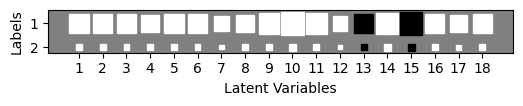

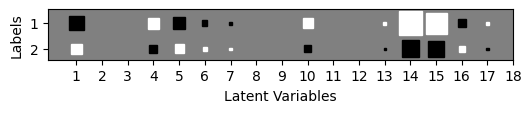

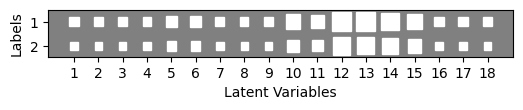

(3, 2)


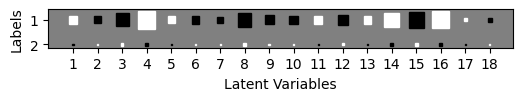

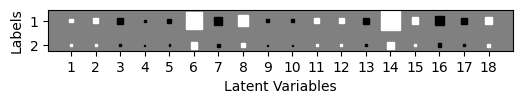

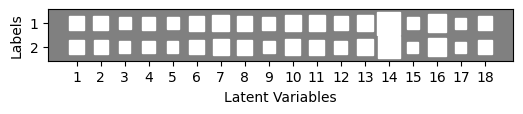

In [214]:
codes_vae = get_important_latents(Rs_vae)
codes_vq = get_important_latents(Rs_vq)

In [237]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[0, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[0, i].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[0, i].set_title(titles[i])
        ax[0, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[1, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[1, i].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[1, i].set_title(titles[i])
        ax[1, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()

In [152]:
latents = indices.view(z.shape[0], -1)
latents.shape

torch.Size([800, 18])

In [252]:
codes_vae

array([[ 9.,  9.],
       [13.,  0.],
       [11., 11.]])

In [259]:
def plot_latents_vs_labels(latents, labels, codes):
    fig, axs = plt.subplots(codes.shape[1], codes.shape[0], figsize=(10, 12))
    titles = ["MLP", "Lasso", "Random Forest"]
    print(codes.shape)
    for i, code in enumerate(codes.T):
        print(code)
        lat1, lat2, lat3 = [int(c) for c in code]
        print(c1)
        axs[i,0].scatter(latents[:,lat1], labels[:,i])
        axs[i,0].set_xlabel("latent {}".format(c1))
        axs[i,0].set_ylabel("z {}".format(i))
        axs[i,0].set_title(titles[i])
        
        axs[i,1].scatter(latents[:,lat2], labels[:,i])
        axs[i,1].set_xlabel("latent {}".format(c2))
        axs[i,1].set_ylabel("z {}".format(i))
        axs[i,0].set_title(titles[i])
        
        axs[i,2].scatter(latents[:,lat3], labels[:,i])
        axs[i,2].set_xlabel("latent {}".format(c2))
        axs[i,2].set_ylabel("z {}".format(i))
        axs[i,0].set_title(titles[i])
    
    

(3, 2)
[ 9. 13. 11.]
13
[ 9.  0. 11.]
13


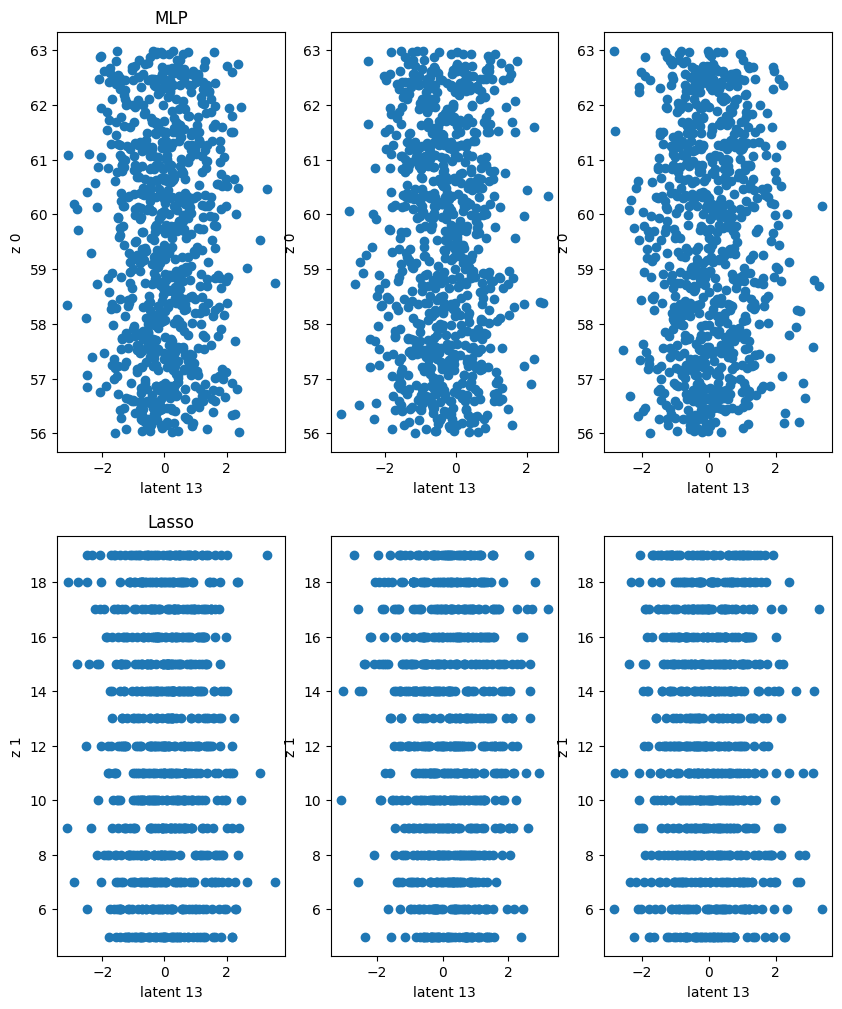

In [260]:
plot_latents_vs_labels(latents, y_train_vq, codes_vae)